In [39]:
import pandas as pd
import numpy as np
import networkx as nx
import pickle as pkl

import scipy as sp
from scipy.sparse.csgraph import minimum_spanning_tree

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import squareform
import community as community_louvain
from wordcloud import WordCloud

## Create Directed Trade Networks of Aggregated Import Value

In [40]:
temp = pd.read_stata("data/country_partner_sitcproductsection_year.dta")

In [41]:
#SITC revision 2 product code definitions
data_dict = pd.read_json('https://comtrade.un.org/data/cache/classificationS2.json')

In [42]:
data_cross = []
i = 0
for item_def in list(data_dict["results"]):
    if(i >= 2):
        data_cross.append(item_def["text"].split(" - ", 1))
    i = i+1

product_codes = pd.DataFrame(data_cross, columns = ['code', 'product'])

In [43]:
country_codes = pd.read_excel("data/ISO3166.xlsx")

#rename some columns for join with trade data
country_codes["location_code"] = country_codes["Alpha-3 code"]
country_codes["partner_code"] = country_codes["Alpha-3 code"]
country_codes["country_i"] = country_codes["English short name"]
country_codes["country_j"] = country_codes["English short name"]
product_codes["sitc_product_code"] = product_codes["code"]

In [44]:
def clean_df(df):
    #join trade data and descriptions
    df = pd.merge(df, country_codes[["location_code", "country_i"]],on = ["location_code"])
    df = pd.merge(df, country_codes[["partner_code", "country_j"]],on = ["partner_code"])
    df = pd.merge(df, product_codes[["sitc_product_code", "product"]], on = ["sitc_product_code"])

    imports1 = df[['location_id', 'partner_id', 'product_id', 'year',
       'import_value', 'sitc_eci', 'sitc_coi', 'location_code', 'partner_code',
       'sitc_product_code', 'country_i', 'country_j', 'product']]
    imports1 = imports1[imports1["import_value"] != 0]

    imports2 = df[['location_id', 'partner_id', 'product_id', 'year',
       'export_value', 'sitc_eci', 'sitc_coi', 'location_code', 'partner_code',
       'sitc_product_code', 'country_i', 'country_j', 'product']]
    imports2["temp1"] = imports2['partner_code']
    imports2["temp2"] = imports2['location_code']

    imports2['location_code'] = imports2["temp1"]
    imports2['partner_code'] = imports2["temp2"]
    imports2["import_value"] = imports2["export_value"]
    imports2 = imports2[imports2["import_value"] != 0]
    imports2 = imports1[['location_id', 'partner_id', 'product_id', 'year',
        'import_value', 'sitc_eci', 'sitc_coi', 'location_code', 'partner_code',
        'sitc_product_code', 'country_i', 'country_j', 'product']]
    
    imports = pd.concat([imports1, imports2], ignore_index=True)
    
    #uk_trade = imports[(imports['location_code'] == 'GBR') | (imports['partner_code'] == 'GBR')]

    trade_agg = imports.groupby(["partner_code","location_code"])["import_value"].sum().reset_index()

    return trade_agg

In [45]:
#import trade data
years_data = []
for i in range(2013,2022):
    file_name = (f"data/country_partner_sitcproduct4digit_year_{i}.dta")
    year_data = pd.read_stata(file_name)
    trade = clean_df(year_data)
    years_data.append(trade)

In [46]:
eu_country_codes = ['GBR','AUT', 'BEL', 'BGR', 'HRV', 'CYP', 'CZE', 'DNK', 'EST', 'FIN', 'FRA', 'DEU', 'GRC', 'HUN', 'IRL', 'ITA', 'LVA', 'LTU', 'LUX', 'MLT', 'NLD', 'POL', 'PRT', 'ROU', 'SVK', 'SVN', 'ESP', 'SWE']

In [47]:
graphs = []

for y in years_data:
    trade_df = pd.DataFrame(
                {
                    "source": list(y['location_code']),
                    "target": list(y['partner_code']),
                    "weight": list(y['import_value'])
                }
            )
    G = nx.from_pandas_edgelist(trade_df, source='source', target='target', edge_attr=True, create_using=nx.DiGraph)

    for i in G.nodes:
        if i in eu_country_codes:
            G.nodes[i]["EU"] = True
        else:
            G.nodes[i]["EU"] = False

    graphs.append(G)

## Visualize Change in Degree Since Brexit was Introduced

In [55]:
germany_in_connec = []
italy_in_connec = []
france_in_connec = []
uk_in_connec = []

germany_out_connec = []
italy_out_connec = []
france_out_connec = []
uk_out_connec = []

for i in graphs:
    germany_in_connec.append(i.in_degree('DEU'))
    italy_in_connec.append(i.in_degree('ITA'))
    france_in_connec.append(i.in_degree('FRA'))
    uk_in_connec.append(i.in_degree('GBR'))

    germany_out_connec.append(i.out_degree('DEU'))
    italy_out_connec.append(i.out_degree('ITA'))
    france_out_connec.append(i.out_degree('FRA'))
    uk_out_connec.append(i.out_degree('GBR'))

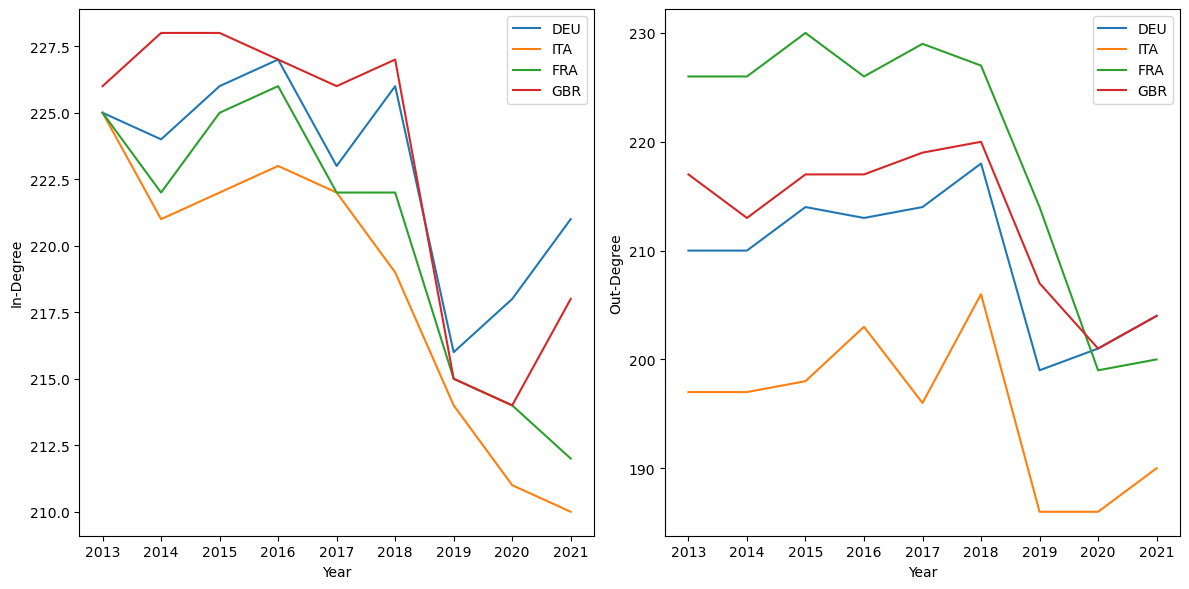

In [62]:
x = range(2013,2022)

# Create a figure and two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot fig1 on the first subplot
axs[0].plot(x, germany_in_connec, label = "DEU")
axs[0].plot(x, italy_in_connec, label = "ITA")
axs[0].plot(x, france_in_connec, label = "FRA")
axs[0].plot(x, uk_in_connec, label = "GBR")

axs[0].set_xlabel("Year")
axs[0].set_ylabel("In-Degree")

# Plot fig1 on the first subplot
axs[1].plot(x, germany_out_connec, label = "DEU")
axs[1].plot(x, italy_out_connec, label = "ITA")
axs[1].plot(x, france_out_connec, label = "FRA")
axs[1].plot(x, uk_out_connec, label = "GBR")

axs[1].set_xlabel("Year")
axs[1].set_ylabel("Out-Degree")

# Adjust layout to prevent overlap
plt.tight_layout()

axs[0].legend()
axs[1].legend()

plt.show()

In [63]:
germany_in_connec = []
italy_in_connec = []
france_in_connec = []
uk_in_connec = []

germany_out_connec = []
italy_out_connec = []
france_out_connec = []
uk_out_connec = []

for i in graphs:
    germany_in_connec.append(i.in_degree('DEU', weight='weight'))
    italy_in_connec.append(i.in_degree('ITA', weight='weight'))
    france_in_connec.append(i.in_degree('FRA', weight='weight'))
    uk_in_connec.append(i.in_degree('GBR', weight='weight'))

    germany_out_connec.append(i.out_degree('DEU', weight='weight'))
    italy_out_connec.append(i.out_degree('ITA', weight='weight'))
    france_out_connec.append(i.out_degree('FRA', weight='weight'))
    uk_out_connec.append(i.out_degree('GBR', weight='weight'))

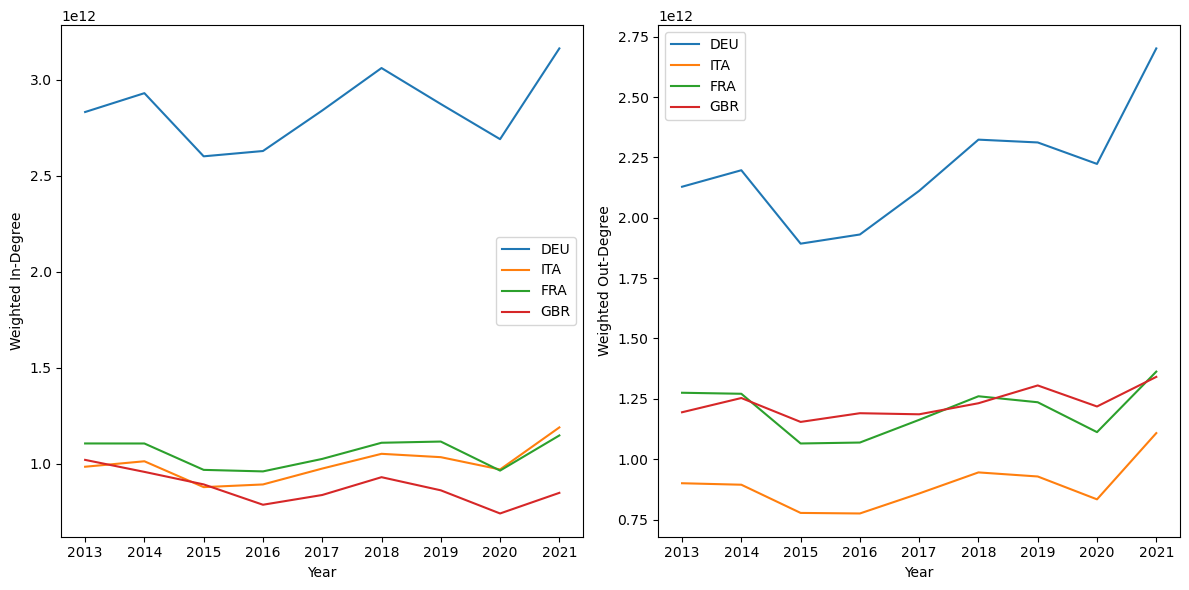

In [65]:
x = range(2013,2022)

# Create a figure and two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot fig1 on the first subplot
axs[0].plot(x, germany_in_connec, label = "DEU")
axs[0].plot(x, italy_in_connec, label = "ITA")
axs[0].plot(x, france_in_connec, label = "FRA")
axs[0].plot(x, uk_in_connec, label = "GBR")

axs[0].set_xlabel("Year")
axs[0].set_ylabel("Weighted In-Degree")

# Plot fig1 on the first subplot
axs[1].plot(x, germany_out_connec, label = "DEU")
axs[1].plot(x, italy_out_connec, label = "ITA")
axs[1].plot(x, france_out_connec, label = "FRA")
axs[1].plot(x, uk_out_connec, label = "GBR")

axs[1].set_xlabel("Year")
axs[1].set_ylabel("Weighted Out-Degree")

# Adjust layout to prevent overlap
plt.tight_layout()

axs[0].legend()
axs[1].legend()

plt.show()